## Import libraries

In [5]:
!pip install matplotlib seaborn pandas numpy scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ----------------------------- ---------- 6.6/8.9 MB 40.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 32.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.7 MB ? eta -:--:--
   ------------ --------------------------- 11.8/38.7 MB 56.8 MB/s eta 0:00:01
   ------------------------ --------------- 23.6/38.7 MB 55.3 MB/s eta 0:00:01
   ------------------------------------ --- 35.7/38.7 MB 55.3 MB/s eta 0:00:01
   ---------------------------------------  38.5/38.7 MB 53.3 MB/s eta 0:00:01
   ---------------------------------------- 38.7/38.7 MB 43.2 MB/s  0:00:00

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- -----------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, classification_report, roc_auc_score, confusion_matrix

import ydf

## Preprocessing dataset and EDA

In [9]:
dataset = pd.read_csv('../dataset/german_credit_data.csv')

dataset.head(20)
dataset['Risk'] = dataset['Risk'].replace({ 0 : "good", 1 : 'bad'})

In [11]:
def preprocess_features( dataset ):

    df_processed = dataset.copy()
    df_processed['Saving accounts'] = df_processed['Saving accounts'].fillna('Unknown')
    df_processed['Checking account'] = df_processed['Checking account'].fillna('Unknown')

    ls_numerical = [ 'Age', 'Credit amount', 'Duration' ]
    ls_nominal = [ 'Sex', 'Saving accounts', 'Checking account', 'Purpose' ]
    ls_ordinal = ['Job']

    nominal_transformer = Pipeline(
        steps=[
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ])

    ordinal_transformer = Pipeline(
        steps=[
            ( 'ordinal', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1) )
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', ls_numerical),
            ('nom', nominal_transformer, ls_nominal),
            ( 'ord', ordinal_transformer, ls_ordinal )
        ],
        remainder='drop'
     )

    X_encoded = preprocessor.fit_transform(df_processed)

    features = (
        ls_numerical + list(preprocessor.named_transformers_['nom'].named_steps['onehot'].get_feature_names_out(ls_nominal)) + list(preprocessor.named_transformers_['ord'].named_steps['ordinal'].get_feature_names_out(ls_ordinal))
     )

    print(f'{features}')

    X_df = pd.DataFrame(X_encoded, columns=features, index=df_processed.index)

    return X_df

In [12]:
dataset.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


In [13]:
X = dataset.drop(columns='Risk')
y = dataset['Risk']

print(f'X = {X}\n')
print(f'y ={y}')

X =      Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             0   67    male    2     own             NaN           little   
1             1   22  female    2     own          little         moderate   
2             2   49    male    1     own          little              NaN   
3             3   45    male    2    free          little           little   
4             4   53    male    2    free          little           little   
..          ...  ...     ...  ...     ...             ...              ...   
995         995   31  female    1     own          little              NaN   
996         996   40    male    3     own          little           little   
997         997   38    male    2     own          little              NaN   
998         998   23    male    2    free          little           little   
999         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration              Purpose  
0      

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

## Basel 3 compliance components

### Probability of default (PD)

Train model on 1000 examples
Model trained in 0:00:00.581852
1.1172537803649902


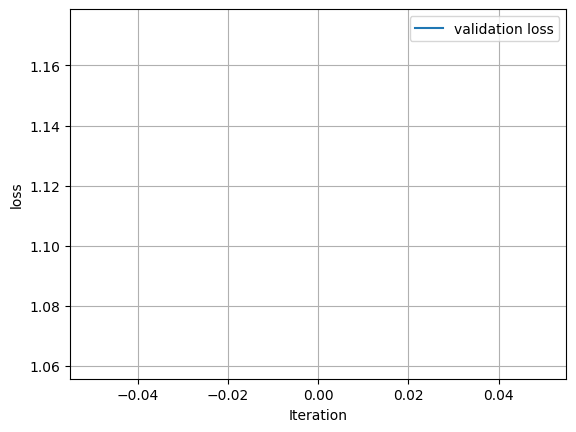

In [ ]:
PDmodel = ydf.GradientBoostedTreesLearner(
    label="Risk",
    num_trees=145,
    early_stopping_num_trees_look_ahead=1000
).train(dataset)

pred_pd_y = PDmodel.predict(X_test)

logs = PDmodel.validation_loss()
print(logs)

# plt.plot( logs, label='validation loss' )
# plt.xlabel('Iteration')
# plt.ylabel('loss')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
y_pred_proba = 1 - PDmodel.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
y_test_numeric = (y_test == 'bad').astype(int)

roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
print(f"PD Model ROC-AUC Score: {roc_auc:.4f}")


print( classification_report( y_test_numeric, y_pred, target_names=['Good', 'Bad'] ) )

PD Model ROC-AUC Score: 0.8954
              precision    recall  f1-score   support

        Good       0.79      0.99      0.88       135
         Bad       0.94      0.45      0.60        65

    accuracy                           0.81       200
   macro avg       0.86      0.72      0.74       200
weighted avg       0.84      0.81      0.79       200



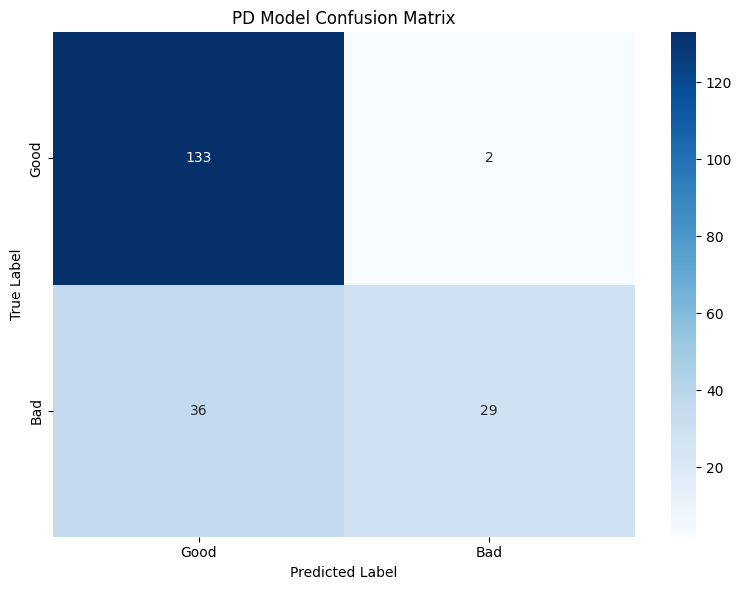

In [ ]:
cm = confusion_matrix(y_test_numeric, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.title('PD Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

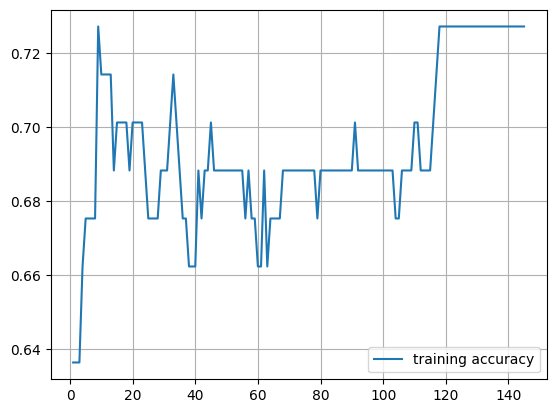

In [ ]:
training_accuracy = [ log.evaluation.accuracy for log in logs ]

plt.plot( iterations, training_accuracy, label='training accuracy' )
plt.legend()
plt.grid()
plt.show()

In [ ]:
ls_pd_pred = []

for predicted_val in PDmodel.predict(X):
    ls_pd_pred.append( float(predicted_val) )

print(ls_pd_pred)

[0.8589126467704773, 0.3267619013786316, 0.8310878872871399, 0.5634552240371704, 0.5807306170463562, 0.8309304714202881, 0.8684715032577515, 0.5840096473693848, 0.8882387280464172, 0.5689727067947388, 0.6133633852005005, 0.3349403440952301, 0.7717191576957703, 0.42116302251815796, 0.7434121370315552, 0.3693232834339142, 0.8621094822883606, 0.6755508780479431, 0.4063386917114258, 0.8431852459907532, 0.8946884870529175, 0.8867499232292175, 0.8920145034790039, 0.7893190383911133, 0.8686575889587402, 0.8513407707214355, 0.8645179867744446, 0.7856947779655457, 0.8855633735656738, 0.41470351815223694, 0.8435055017471313, 0.5780087113380432, 0.767310619354248, 0.8795204758644104, 0.828775942325592, 0.44567209482192993, 0.7858819365501404, 0.7898672223091125, 0.7530323266983032, 0.7979558110237122, 0.8364344835281372, 0.688255786895752, 0.7304364442825317, 0.5588904619216919, 0.40948259830474854, 0.8823994398117065, 0.8471642732620239, 0.7488312721252441, 0.7255372405052185, 0.8805791139602661

In [ ]:
# tuner = ydf.RandomSearchTuner(num_trials=50)
# tuner.choice("shrinkage", [0.2, 0.1, 0.05])
# tuner.choice("subsample", [1.0, 0.9, 0.8])
# tuner.choice("max_depth", [3, 4, 5, 6])

# model_01 = ydf.GradientBoostedTreesLearner(label='Success', tuner=tuner, num_trees=100).train(dataset)
# model_01.describe()

## Loss given default (LGD)

In [ ]:
def generate_synthetic_lgd_col( dataset ):

    """
    Basel III ranges an LGD of 45% on unsecured loans.
    """

    lgd = []

    np.random.seed(42)

    for _, row in dataset.iterrows():

        # collateral: housing
        if ( row['Housing'] == 'own' ): base_lgd = 0.30
        elif ( row['Housing'] == 'rent'): base_lgd = 0.50
        else: base_lgd = 0.45

        # loan purpose
        if ( row['Purpose'] in ['car', 'radio/TV', 'furniture/equipment'] ): base_lgd += 0.05
        elif ( row['Purpose'] == 'education' ): base_lgd -= 0.10

        lgd_val = base_lgd + np.random.normal( 0, 0.05 )
        lgd.append( np.clip( lgd_val, 0.1, 0.9 )  )

    return np.array( lgd )

In [ ]:
LGDModel = RandomForestRegressor(n_estimators=100, random_state=42)

dataset['LGD_synthetic'] = generate_synthetic_lgd_col(dataset)

lgd_X = X
lgd_X_encoded = preprocess_features( lgd_X )
lgd_y = dataset['LGD_synthetic']

X_lgd_train, X_lgd_test, y_lgd_train, y_lgd_test = train_test_split( lgd_X_encoded, lgd_y, test_size=0.2, random_state=42 )
LGDModel.fit(X_lgd_train, y_lgd_train)

lgd_X_encoded.dtypes

LGDModel.fit(X_lgd_train, y_lgd_train)

['Age', 'Credit amount', 'Duration', 'Sex_male', 'Saving accounts_little', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 'Checking account_little', 'Checking account_moderate', 'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'Job']


RandomForestRegressor(random_state=42)

In [ ]:
y_lgd_pred = LGDModel.predict( X_lgd_test )

print( f'y_lgd_pred:\n{y_lgd_pred}' )

y_lgd_pred:
[0.45165327 0.38229095 0.4417918  0.39001121 0.43830575 0.4096549
 0.41378607 0.42291891 0.47739317 0.38063513 0.35168703 0.33957265
 0.38089813 0.40739747 0.32975427 0.39088517 0.46611968 0.40261549
 0.45014747 0.46677227 0.42185114 0.18504391 0.38478589 0.42822606
 0.35128936 0.46963695 0.37176843 0.3882719  0.4323465  0.37292211
 0.38860691 0.39832554 0.38161011 0.37833777 0.38367708 0.39471565
 0.37205573 0.35503586 0.34932619 0.48524477 0.32430944 0.27725176
 0.43464437 0.33189344 0.38073162 0.3873258  0.4202741  0.38927864
 0.37478203 0.50666921 0.4935125  0.39810494 0.43748855 0.3738406
 0.38654236 0.31359116 0.43750084 0.41565288 0.23976628 0.37052854
 0.5264456  0.42177099 0.34723277 0.35392692 0.51637077 0.3495556
 0.42801888 0.42330667 0.34918222 0.35535541 0.40775304 0.46068641
 0.40510269 0.39094664 0.4636983  0.37945426 0.45810563 0.40283296
 0.40931656 0.37150668 0.36248337 0.36827929 0.36029195 0.39394454
 0.25575427 0.42703979 0.44243942 0.48334239 0.386342

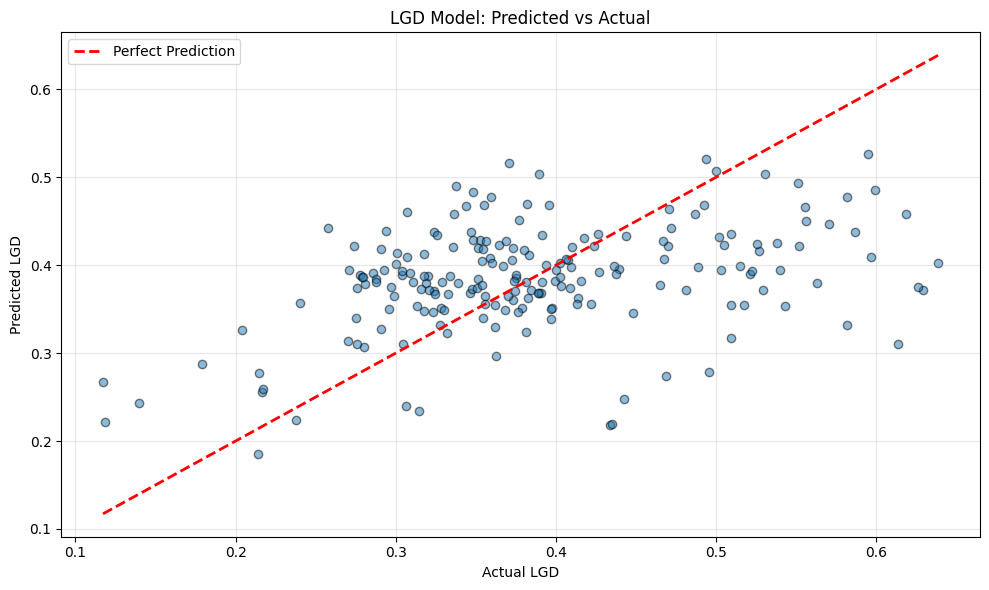

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_lgd_test, y_lgd_pred, alpha=0.5, edgecolor='k')
plt.plot([y_lgd_test.min(), y_lgd_test.max()],
         [y_lgd_test.min(), y_lgd_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual LGD')
plt.ylabel('Predicted LGD')
plt.title('LGD Model: Predicted vs Actual')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.savefig('../img/lgd_model_performance.png')

## Exposure at default (EAD)

In [ ]:
def calculate_ead_col( amount_lent, duration: int, months_passed=0 ):

    """
    EAD - metric showing how much the lender can manage the loss
    """

    montly_rate = 0.11 / 12

    if ( months_passed == 0 ): return amount_lent
    # NOTE: for german_credit_data.csv this is always true as the data is from when the loans
    # were accepted or not

    return

## Calculating expected loss (EL) - Basel III formula

In [ ]:
# EL = PD * LGD * EAD

dataset['PD'] = 1 - PDmodel.predict( X )        # inversion - model counts
dataset['LGD'] = generate_synthetic_lgd_col( dataset )
dataset['EAD'] = dataset.apply( lambda row: calculate_ead_col( row['Credit amount'], row['Duration']), axis=1 )

dataset['expected_loss'] = dataset['PD'] * dataset['LGD'] * dataset['EAD']

dataset.head(100)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,LGD_synthetic,PD,LGD,EAD,expected_loss
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good,0.374836,0.141087,0.374836,1169,61.822072
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,0.343087,0.673238,0.343087,5951,1374.556593
2,2,49,male,1,own,little,NaN,2096,12,education,good,0.232384,0.168912,0.232384,2096,82.273333
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,0.576151,0.436545,0.576151,7882,1982.448516
4,4,53,male,2,free,little,little,4870,24,car,bad,0.488292,0.419269,0.488292,4870,997.015739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,58,male,2,rent,little,moderate,15945,54,business,bad,0.426824,0.680275,0.426824,15945,4629.756774
96,96,61,female,2,own,NaN,NaN,2012,12,education,good,0.214806,0.134876,0.214806,2012,58.292075
97,97,34,male,2,own,moderate,moderate,2622,18,business,good,0.313053,0.232689,0.313053,2622,190.997109
98,98,36,male,2,own,little,moderate,2337,36,radio/TV,good,0.350256,0.415990,0.350256,2337,340.507866


## Conclusion

In [ ]:
def assign_risk_segment(pd):
    """
    Basel III regulatory risk segments based on PD thresholds
    """
    if pd < 0.10:
        return 'Very Low Risk'
    elif pd < 0.25:
        return 'Low Risk'
    elif pd < 0.50:
        return 'Medium Risk'
    elif pd < 0.75:
        return 'High Risk'
    else:
        return 'Very High Risk'

dataset['Risk_Segment'] = dataset['PD'].apply(assign_risk_segment)

# Portfolio Risk Summary
risk_summary = dataset.groupby('Risk_Segment').agg({
    'expected_loss': ['sum', 'mean', 'count'],
    'PD': 'mean',
    'LGD': 'mean',
    'EAD': 'sum'
}).round(2)

print(risk_summary)

               expected_loss                   PD   LGD      EAD
                         sum     mean count  mean  mean      sum
Risk_Segment                                                    
High Risk          138158.87  1161.00   119  0.58  0.40   578492
Low Risk            84024.50   171.13   491  0.16  0.38  1345108
Medium Risk        203763.70   523.81   389  0.38  0.40  1331986
Very High Risk       3329.39  3329.39     1  0.75  0.28    15672


In [ ]:
plt.figure(figsize=(12, 6))
segment_el = dataset.groupby('Risk_Segment')['expected_loss'].sum().sort_values(ascending=False)
colors = ['green', 'lightgreen', 'yellow', 'orange', 'red']
segment_el.plot(kind='bar', color=colors[:len(segment_el)], edgecolor='black')
plt.title('Total Expected Loss by Risk Segment')
plt.ylabel('Expected Loss (€)')
plt.xlabel('Risk Segment')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('../img/expected_loss_by_risk_segment.png')

# 2. PD Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(dataset['PD'], bins=50, edgecolor='black', color='steelblue')
plt.axvline(dataset['PD'].mean(), color='red', linestyle='--',
            label=f'Mean PD: {dataset["PD"].mean():.2%}')
plt.axvline(dataset['PD'].median(), color='green', linestyle='--',
            label=f'Median PD: {dataset["PD"].median():.2%}')
plt.title('Distribution of Probability of Default (PD)')
plt.xlabel('Probability of Default')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('../img/pd_distribution.png')

# 3. Risk Segment Pie Chart
plt.figure(figsize=(10, 8))
segment_counts = dataset['Risk_Segment'].value_counts()
colors_pie = ['green', 'lightgreen', 'yellow', 'orange', 'red']
plt.pie(segment_counts, labels=segment_counts.index,
        startangle=90, colors=colors_pie, explode=[0.05]*len(segment_counts))
plt.title('Portfolio Composition by Risk Segment')
plt.tight_layout()
plt.show()
plt.savefig('../img/risk_segment_pie_chart.png')

NameError: name 'plt' is not defined